Reference
* https://lazyprogrammer.me/bayes-classifier-and-naive-bayes-tutorial-using/
* https://www.twblogs.net/a/5c9109aabd9eee35fc1579bc
* https://blog.csdn.net/qq_31584013/article/details/88543933

$${\textrm{Paremeter} \, \theta, \, \textrm{Data} \, D}$$
$${Posterior=\displaystyle\frac{Likelihood\times Prior}{Evidence}}$$

$${P(\theta|D)=\displaystyle\frac{P(D|\theta)P(\theta)}{P(D)}}$$

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from math import exp, sqrt, pi, log

# For both
digit_class = [[i]for i in range(10)]
prior = [ _ for i in range(10)]

# For discrete
bin_count = [ [ [ 10**-6 for _ in range(32)] for _ in range(28*28)] for _ in range(10)]
posterior_dis = [ [ []for _ in range(10)] for _ in range(10000)]

# For continuous
mean = [ [ []for _ in range(28*28)] for _ in range(10)]
var = [ [ []for _ in range(28*28)] for _ in range(10)]
posterior = [ [ []for _ in range(10)] for _ in range(10000)]

In [15]:
class ubyte_file():
    def __init__(self, filename):
        self.filename = filename
        self.data = []
        
    def read_images(self):
        with open(self.filename, "rb") as f:
            
            # magic number
            byte = f.read(4)
            #print(int.from_bytes(byte,byteorder='big'))
        
            # number of imgs
            byte = f.read(4)
            self.n_images = int.from_bytes(byte,byteorder='big')
        
            # number of rows
            byte = f.read(4)
            self.n_rows = int.from_bytes(byte,byteorder='big')
    
            # number of columns
            byte = f.read(4)
            self.n_cols = int.from_bytes(byte,byteorder='big')
        
            # data
            for i in range(self.n_images):
                byte = f.read(self.n_rows * self.n_cols)
                #print(byte)
                #print(int.from_bytes(byte,byteorder='big'))
                self.data.append(byte)
            
            #print(len(self.data))
            
    def read_labels(self):
        with open(self.filename, "rb") as f:
            
            # magic number
            byte = f.read(4)
            #print(int.from_bytes(byte,byteorder='big'))
        
            # number of imgs
            byte = f.read(4)
            self.n_images = int.from_bytes(byte,byteorder='big')
        
            # data
            for i in range(self.n_images):
                byte = f.read(1)
                #print(byte)
                #print(int.from_bytes(byte,byteorder='big'))
                self.data.append(byte)
            
            #print(len(self.data))
            
            
  

In [16]:
train_images = ubyte_file("train-images.idx3-ubyte")
train_images.read_images()
    
train_labels = ubyte_file("train-labels.idx1-ubyte")
train_labels.read_labels()
    
test_images = ubyte_file("t10k-images.idx3-ubyte")
test_images.read_images()
    
test_labels = ubyte_file("t10k-labels.idx1-ubyte")
test_labels.read_labels()

In [17]:
def plot_image(byte):
        
    image = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            image[i,j] = byte[i*28 + j]
                
    plt.imshow(image, cmap='gray')

In [18]:
# Separate images by class
def separate_images_by_class():
    for i in range(len(train_labels.data)):
        digit_class[int.from_bytes(train_labels.data[i], byteorder='big')].append(i)
    #print(digit_class[0])
    
    
# Prior
def Prior():
    for i in range(10):
        prior[i] = (len(digit_class[i])-1) / 60000
    #print(prior)
    
    
# Normalize
def normalize(list):
    return [i/sum(list) for i in list]

In [19]:
# Bin count
def Bin_count():
    
    for i in range(10): # i: digit
        #print(i)
        for j in range(28*28): # j: pixel
            k = 1
            while k < len(digit_class[i]): # k: image
                pixel = train_images.data[digit_class[i][k]][j]
                #for b in range(32): # b: bin
                #    if b*8<=pixel and pixel<(b+1)*8:
                #        bin_count[i][j][b] += 1
                #        break
                bin_count[i][j][pixel//8] += 1
                k += 1

    #print(digit_class[0])
    #print(bin_count[0][0])
    #print(bin_count[0][128])
    
    
# Likelihood
def likelihood(im_index):
    likeli = [ [ []for _ in range(28*28)] for _ in range(10)]
    
    for i in range(10): # i: digit
        for j in range(28*28): # j: pixel
            pixel = test_images.data[im_index][j]
            pixel_belongs_to_bin = -1
            #for k in range(32): # k: bin
            #    if k*8<=pixel and pixel<(k+1)*8:
            #        pixel_belongs_to_bin = k
            #        break
            likeli[i][j] = bin_count[i][j][pixel//8] / (len(digit_class[i])-1)
    #print(gauss[0])
    return likeli

#a = likelihood(0)
#print(len(a[0]))


# Posterior for discrete
def Posterior_dis():

    for i in range(10000): # i: test image index
        #print(i)
        likeli = likelihood(i)
        for j in range(10): # j: digit
            s = 0
            for k in range(28*28): # k:pixel
                s += log(likeli[j][k])
            posterior_dis[i][j] = s + log(prior[j])

    #print(posterior_dis[0])
    #print(posterior_dis[1])

In [20]:
# Output for discrete
def Output_dis():
    error_count = 0

    # 1. Posterior, prediction and true label
    for i in range(10000): # i: test image index
        print("Posterior (in log scale):")
        for j in range(10): # j: digit
            print("{}: {}".format(j, normalize(posterior_dis[i])[j]))
        predict = np.argmin(normalize(posterior_dis[i]))
        true_label = int.from_bytes(test_labels.data[i], byteorder='big')
        print("Prediction: {}, Ans: {}".format(predict, true_label))
        print()
        if(predict != true_label):
            error_count += 1
            
    # 2. Imagination of numbers
    print("Imagination of numbers in Bayesian classifier:")
    print()
    for i in range(10): # i: digit
        print("{}:".format(i))
        for j in range(28):
            for k in range(28):
                bin_low = 0
                bin_high = 0
                for b in range(16): # b: bin
                    bin_low += bin_count[i][j*28+k][b]
                    bin_high+= bin_count[i][j*28+k][b+16]
                #print(bin_low)
                #print(bin_high)
                if(bin_low > bin_high):
                    print(0,end=' ')
                else:
                    print(1,end=' ')
            print()
        print()

    # 3. Error rate
    print("Error rate: {}".format(error_count/10000))
    

In [21]:
def discrete():
    
    Bin_count()
    
    Posterior_dis()
    
    Output_dis()
    

Variance
$${Var(X)=\displaystyle\frac{1}{n}\sum_{i=1}^{n}{(x_{i}-\mu)^{2}}}$$


Gaussian distribution, 1D

$${\textrm{Parameters: mean}\,\mu, \textrm{variance}\, \sigma^{2}}$$
$${N(x;\mu,\sigma)=\displaystyle\frac{1}{\sqrt{2\pi\sigma^{2}}}exp\big[-\displaystyle\frac{1}{2}(x-\mu)^{2}/\sigma^{2}\big]}$$


Gaussian distribution, Dimension D
$${\textrm{variance}\,\textstyle\sum}$$

$${P(x|c)=\displaystyle\frac{1}{\sqrt{(2\pi)^{D}|\textstyle\sum|}}exp\big(-\displaystyle\frac{1}{2}(x-\mu)^{T}\textstyle\sum^{-1}(x-\mu)\big)}$$

$${logP(x|c)=-\displaystyle\frac{D}{2}ln(2\pi)-\displaystyle\frac{1}{2}ln|\textstyle\sum|-\displaystyle\frac{1}{2}(x-\mu)^{T}\textstyle\sum^{-1}(x-\mu)}$$

In [22]:
# Mean
def Mean():

    for i in range(10): # i: digit
        for j in range(28*28): # j: pixel
            #print(j)
            s = 0
            k = 1
            while k < len(digit_class[i]): # k: image
                s += train_images.data[digit_class[i][k]][j]
                k += 1
            mean[i][j] = s / (len(digit_class[i]) -1)
    #print(mean[0])
    #print(mean[1])
    
    
# Variance
def Variance():

    for i in range(10): # i: digit
        for j in range(28*28): # j: pixel
            #print(j)
            s = 0
            k = 1
            while k < len(digit_class[i]): # k: image
                #print(mean[i][j])
                s += (train_images.data[digit_class[i][k]][j] - mean[i][j])**2
                k += 1
            var[i][j] = s / (len(digit_class[i]) -1)
            if var[i][j] <= 10**3:
                var[i][j] = 10**3
    #print(var[0])
    
    
# Gaussian
def gaussian(im_index):
    gauss = [ [ []for _ in range(28*28)] for _ in range(10)]
    
    for i in range(10): # i: digit
        for j in range(28*28): # j: pixel
            gauss[i][j] = -1/2*log(2*pi) - (1/2*log(var[i][j])) - (1/2*(test_images.data[im_index][j] - mean[i][j])**2 / var[i][j])
    #print(gauss[0])
    return gauss
#gaussian(0)


# Posterior for continuous
def Posterior():

    for i in range(10000): # i: test image index
        #print(i)
        gauss = gaussian(i)
        for j in range(10): # j: digit
            s = 0
            for k in range(28*28): # k:pixel
                #print(gaussian(i)[j][k])
                s += (gauss[j][k])
            posterior[i][j] = s + log(prior[j])

    #print(posterior[0])
    #print(posterior[1])
    

In [23]:
# Output
def Output():
    error_count = 0

    # 1. Posterior, prediction and true label
    for i in range(10000): # i: test image index
        print("Posterior (in log scale):")
        for j in range(10): # j: digit
            print("{}: {}".format(j, normalize(posterior[i])[j]))
        predict = np.argmin(normalize(posterior[i]))
        true_label = int.from_bytes(test_labels.data[i], byteorder='big')
        print("Prediction: {}, Ans: {}".format(predict, true_label))
        print()
        if(predict != true_label):
            error_count += 1
    
    # 2. Imagination of numbers
    print("Imagination of numbers in Bayesian classifier:")
    print()
    for i in range(10):
        print("{}:".format(i))
        for j in range(28):
            for k in range(28):
                if(mean[i][j*28+k] < 128):
                    print(0,end=' ')
                else:
                    print(1,end=' ')
            print()
        print()

    # 3. Error rate
    print("Error rate: {}".format(error_count/10000))

In [24]:
# Continuous

def continuous():

    # Mean
    Mean()
    
    # Variance
    Variance()

    # Posterior
    Posterior()
    
    # Output
    Output()


In [25]:
def main():
    print("Input 0 for discrete mode; 1 for continuous mode")
    
    mode = input()
    
    plot_image(test_images.data[0])
    #print(train_images.data[1][126]) 
    #print(train_images.data[1][127]) 
    #print(train_images.data[1][128]) 
    #print(train_images.data[1][129]) 
    #print(train_images.data[1]) 
    
    # Separate images by class
    separate_images_by_class()

    # Prior
    Prior()
    
    if int(mode) == 0:
        discrete()
    else:
        continuous()


Input 0 for discrete mode; 1 for continuous mode
1
Posterior (in log scale):
0: 0.1016395456070429
1: 0.11185545952217758
2: 0.10188204321632653
3: 0.09810507738896787
4: 0.09721318504610797
5: 0.09851801533113187
6: 0.10634315564461945
7: 0.09140445213171912
8: 0.09835884263659947
9: 0.09468022347530718
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.09704621692406201
1: 0.10825159588397085
2: 0.08887130496384262
3: 0.0933846030093403
4: 0.10491205923626071
5: 0.09545161045080855
6: 0.09260843774925905
7: 0.11423881744470966
8: 0.09636162814811894
9: 0.10887372618962722
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10735972088443221
1: 0.09245819015522659
2: 0.10001131489917353
3: 0.10018507576631981
4: 0.10017868723400196
5: 0.09957654241478583
6: 0.10035782077926593
7: 0.10029362760383556
8: 0.09949556759813073
9: 0.10008345266482793
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.09003326282860319
1: 0.1316211891558214
2: 0.09614085553091818
3: 0.096401634313931

7: 0.1022437635849199
8: 0.09805110071197648
9: 0.10010132218900834
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.1062356141380809
1: 0.11785040395681534
2: 0.09931030160237664
3: 0.09796088689987346
4: 0.09583751256828096
5: 0.09735153429554293
6: 0.09943194926984587
7: 0.09800928557456214
8: 0.09316648097471122
9: 0.09484603071991057
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.09940352269907615
1: 0.11480939902550422
2: 0.09260330023726461
3: 0.09635357148297666
4: 0.10027923693143619
5: 0.0951114273050881
6: 0.0971238605499252
7: 0.10680440281721428
8: 0.09312700165924521
9: 0.10438427729226941
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10713267364601921
1: 0.09314276599722457
2: 0.10064694777222401
3: 0.09981695086588019
4: 0.10073120334115414
5: 0.09945840859498205
6: 0.09996625547353147
7: 0.09987868449231425
8: 0.09992006286153837
9: 0.09930604695513166
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10447554099435338
1: 0.09838226827633725
2: 

3: 0.10441233520297863
4: 0.09236584301394855
5: 0.09965121319814949
6: 0.08841064895585504
7: 0.10227811085215814
8: 0.0988119450701699
9: 0.10042584493610414
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10394973580248541
1: 0.11109706434794284
2: 0.1018919182014601
3: 0.09766239819181492
4: 0.09676252474090852
5: 0.09661838282732527
6: 0.10151977666789311
7: 0.09867894223518557
8: 0.095605677692931
9: 0.09621357929205322
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.10315378321987462
1: 0.10865382784748624
2: 0.10389025149870172
3: 0.09696015090184261
4: 0.09608211437045937
5: 0.09482757778791359
6: 0.10977265069649707
7: 0.0969005901905205
8: 0.09522251618504676
9: 0.09453653730165752
Prediction: 9, Ans: 5

Posterior (in log scale):
0: 0.10994521741674128
1: 0.0980852770207049
2: 0.10027424420393112
3: 0.09940277787894106
4: 0.09838632980021572
5: 0.09840472162300302
6: 0.10584144696578049
7: 0.09651638715612419
8: 0.09734779966381835
9: 0.09579579827073996
Predicti

0: 0.10918751361167052
1: 0.10251147943533306
2: 0.09914761531571724
3: 0.0984970676065579
4: 0.09764158137975214
5: 0.09813610154604582
6: 0.10178791049048651
7: 0.09946765674232294
8: 0.0965853088172293
9: 0.09703776505488469
Prediction: 8, Ans: 7

Posterior (in log scale):
0: 0.101085902563452
1: 0.11951471216539623
2: 0.09751738304807098
3: 0.09220139148022943
4: 0.09570274022624595
5: 0.09224649219747373
6: 0.1072956998054484
7: 0.10589846814044676
8: 0.0910946128633656
9: 0.09744259750987104
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.10542586847166939
1: 0.09463734271524486
2: 0.10065106408372956
3: 0.09848285391779651
4: 0.10141072008874964
5: 0.09886023203594385
6: 0.09984586075064365
7: 0.10178713783090615
8: 0.0992770296919763
9: 0.09962189041334005
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10215830963921736
1: 0.1239785981688112
2: 0.09767784109746587
3: 0.09623506096671641
4: 0.09163595887047996
5: 0.09694500599932049
6: 0.10205570835674405
7: 0.09798

Posterior (in log scale):
0: 0.10695619117338685
1: 0.09675957256467768
2: 0.09918661615569514
3: 0.09970048867609523
4: 0.10021558097209439
5: 0.09900012010445727
6: 0.09648448893902623
7: 0.10296570326918385
8: 0.09870329710542138
9: 0.10002794103996207
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10129900188351565
1: 0.1177476658520693
2: 0.10369275052200166
3: 0.09877565332106426
4: 0.09533163149500429
5: 0.09725930986273802
6: 0.10258348692147039
7: 0.09397380512441414
8: 0.09714256273859483
9: 0.09219413227912747
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.09937286065590982
1: 0.10688627066711294
2: 0.09841357496293544
3: 0.09837444150436685
4: 0.09864413400788524
5: 0.0955060707525424
6: 0.09822575968790052
7: 0.10659670236680875
8: 0.09541453271284644
9: 0.10256565268169163
Prediction: 8, Ans: 6

Posterior (in log scale):
0: 0.09177185169991413
1: 0.13803945576533264
2: 0.09747136980120641
3: 0.09443381942599416
4: 0.09328328198405599
5: 0.09311861690730724
6

Prediction: 6, Ans: 0

Posterior (in log scale):
0: 0.09328372521701525
1: 0.12781695665165388
2: 0.097026675995037
3: 0.09614118419394785
4: 0.09759989409444664
5: 0.09516304920330107
6: 0.09783936138515854
7: 0.10188948634512264
8: 0.09478935577443595
9: 0.09845031113988109
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.09867737237817066
1: 0.12597924868207727
2: 0.08923555920618101
3: 0.09503501402080174
4: 0.09689056887515514
5: 0.09467986115561332
6: 0.09015195854969263
7: 0.10657972703973086
8: 0.09772080756307977
9: 0.10504988252949751
Prediction: 2, Ans: 6

Posterior (in log scale):
0: 0.09766728429769041
1: 0.11424820748703096
2: 0.09635283294020021
3: 0.09749363746334534
4: 0.10022176378120169
5: 0.09633522954014373
6: 0.09206117991503135
7: 0.1067966534353499
8: 0.0970592244424131
9: 0.10176398669759354
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10434128400574064
1: 0.1029587612679779
2: 0.09503837977102718
3: 0.09712538550939191
4: 0.10199602421348779
5: 0

7: 0.10520106352118892
8: 0.09522083564141429
9: 0.09865293143576499
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.0956099959355503
1: 0.11694042900115381
2: 0.09678206895981546
3: 0.09658200443513328
4: 0.10063300913799458
5: 0.09606982616219117
6: 0.09336015078130293
7: 0.1047777568375332
8: 0.09705362205955334
9: 0.10219113668977185
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10978050679263854
1: 0.09146184966499525
2: 0.09785054610552003
3: 0.0997443900491318
4: 0.09939589732923215
5: 0.09847028446135964
6: 0.10275201944099614
7: 0.10178462940828108
8: 0.0972308183755392
9: 0.10152905837230625
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10258066777175287
1: 0.12086794086913387
2: 0.10098000071537072
3: 0.09857564935004204
4: 0.09452852878113881
5: 0.09673122226465193
6: 0.1002485605191785
7: 0.0959938376128596
8: 0.09686805240463289
9: 0.09262553971123863
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.10045762286624542
1: 0.12350251070650092
2: 0.


Posterior (in log scale):
0: 0.10737371993204037
1: 0.10993684625489174
2: 0.10047094596516604
3: 0.09839986556117146
4: 0.0949123624027475
5: 0.09719459432997807
6: 0.10115679538726813
7: 0.09895268562912395
8: 0.09638198938315876
9: 0.09522019515445405
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.10959262181548984
1: 0.09642827213098944
2: 0.09899734862641617
3: 0.09892859902618673
4: 0.09970574550100457
5: 0.09822952176283754
6: 0.09782528156698826
7: 0.10325577613453647
8: 0.09672871374536515
9: 0.10030811969018602
Prediction: 1, Ans: 8

Posterior (in log scale):
0: 0.10478419628502239
1: 0.10546893398383841
2: 0.09337989626345726
3: 0.09520381046811391
4: 0.10099944995616486
5: 0.09780512684440411
6: 0.09803780310242853
7: 0.1017745336937553
8: 0.0985425362000928
9: 0.1040037132027224
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10355674351308486
1: 0.1042571608338305
2: 0.10180717570846315
3: 0.10023428454471298
4: 0.09847915958723669
5: 0.09821593742593643
6: 

1: 0.0971948749955058
2: 0.09400480907934243
3: 0.09765992975413289
4: 0.10320956946243497
5: 0.09725749741242776
6: 0.09766352670295751
7: 0.1051723887041415
8: 0.09698344764528334
9: 0.10615316642648287
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10546625545257271
1: 0.10658442433630368
2: 0.1035607527044396
3: 0.09904744388079682
4: 0.09736553250895136
5: 0.09803051343479183
6: 0.10172766616213812
7: 0.09558479962126547
8: 0.09820322711038376
9: 0.09442938478835666
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.09483639472595716
1: 0.10868067093427951
2: 0.08803188453093302
3: 0.09068859811356454
4: 0.10514256522701337
5: 0.09301629686043296
6: 0.0964608294457552
7: 0.11712648608789493
8: 0.09440387340187849
9: 0.11161240067229088
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.09700962776711042
1: 0.13415255304830306
2: 0.10031589175157603
3: 0.10148794297584773
4: 0.0891568737149218
5: 0.09428363225699922
6: 0.09977983310962386
7: 0.09587091809266832
8: 0.09

0: 0.088764775062359
1: 0.12744137291773003
2: 0.09490643517375129
3: 0.09728206950004067
4: 0.09731631840236206
5: 0.09389012182140688
6: 0.09843235152968365
7: 0.10518261020056051
8: 0.09423306239106147
9: 0.10255088300104455
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.1031315442720116
1: 0.1084549734841601
2: 0.09740983096917868
3: 0.0991595785104073
4: 0.09790090929941582
5: 0.09831887655439621
6: 0.09453608581559107
7: 0.10172311399789324
8: 0.09906023780062115
9: 0.10030484929632462
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.1043974175143043
1: 0.10414478232703837
2: 0.09551918959636112
3: 0.0922360052222914
4: 0.09951977018941977
5: 0.09757515653709475
6: 0.10091158390793584
7: 0.10483334276615734
8: 0.09851930721798963
9: 0.10234344472140744
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.09937803332407666
1: 0.11890190734700645
2: 0.10519641176010722
3: 0.09570415339848838
4: 0.09480200556651905
5: 0.09121394445737999
6: 0.11261152364299704
7: 0.0962

8: 0.09707414863285743
9: 0.10504384967522383
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10803561036740175
1: 0.1019838066462294
2: 0.09900713076094789
3: 0.0978434842093115
4: 0.09914398583467172
5: 0.09765455363463327
6: 0.10175991320563442
7: 0.1006751982083826
8: 0.09487485887405182
9: 0.09902145825873565
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.0977117708594225
1: 0.11347861086814598
2: 0.09263641250865019
3: 0.09498850114154596
4: 0.10306925561182963
5: 0.0956861786202799
6: 0.0969371524570689
7: 0.1026314236571084
8: 0.0976793310086568
9: 0.10518136326729186
Prediction: 2, Ans: 1

Posterior (in log scale):
0: 0.1032074410122693
1: 0.10567847062161137
2: 0.09946339009122768
3: 0.09278357265828263
4: 0.09806242024120397
5: 0.09540909180191473
6: 0.10607606973843275
7: 0.10348529706832825
8: 0.09571885967207173
9: 0.10011538709465787
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.10165980859713698
1: 0.12347649377086714
2: 0.10181002039744247
3: 0.099

4: 0.09813570593345923
5: 0.09489665225781092
6: 0.10206797142613566
7: 0.11063923639056603
8: 0.09514466575902111
9: 0.10283510105451273
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.09773979989922016
1: 0.12494996988754853
2: 0.09775738171113607
3: 0.10168308251923133
4: 0.08997896575126346
5: 0.09658832942076691
6: 0.09904609774063254
7: 0.09761630890249033
8: 0.09985862706239468
9: 0.09478143710531603
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.10717601686727345
1: 0.10083015023636102
2: 0.09643262941401876
3: 0.09892137348825933
4: 0.09971851883383706
5: 0.09769329122218738
6: 0.09400489480794486
7: 0.10637936492562405
8: 0.09668391846570047
9: 0.1021598417387938
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.09623272164109299
1: 0.1247999008760057
2: 0.10187369250699468
3: 0.09842084472050362
4: 0.0952217002730824
5: 0.09735593112773237
6: 0.1012550796289131
7: 0.09300332767987787
8: 0.09737607317403321
9: 0.09446072837176413
Prediction: 7, Ans: 7

Poster

7: 0.10516249382498018
8: 0.09505319265740705
9: 0.10484684197887802
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.10344107499488273
1: 0.09900317395772386
2: 0.0951784958227262
3: 0.09500190358512754
4: 0.10185978104403878
5: 0.09687121342751503
6: 0.09947667714473196
7: 0.10784631808070733
8: 0.09646465778549376
9: 0.10485670415705278
Prediction: 3, Ans: 2

Posterior (in log scale):
0: 0.10192354818943367
1: 0.12292320269410692
2: 0.09268957709902803
3: 0.0961655909785759
4: 0.09734266274400148
5: 0.09468244571926336
6: 0.08881416782205401
7: 0.10971142422123203
8: 0.09436495387591047
9: 0.1013824266563941
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.09725480992226881
1: 0.11033183265343116
2: 0.09879033165548867
3: 0.09754739611972661
4: 0.09994486534014341
5: 0.0968205455218516
6: 0.09912846630447432
7: 0.10240706127701471
8: 0.09751485274367448
9: 0.10025983846192629
Prediction: 5, Ans: 0

Posterior (in log scale):
0: 0.1073548540721623
1: 0.09298667781500806
2: 0


Posterior (in log scale):
0: 0.10900478371893878
1: 0.11239016703028439
2: 0.10111863006695915
3: 0.09792714169552157
4: 0.09507316515601293
5: 0.09710658254999659
6: 0.10137314748147921
7: 0.09551663951677496
8: 0.09643051303669821
9: 0.09405922974733429
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.10146060749765395
1: 0.11000770742518205
2: 0.10068398536003757
3: 0.09878560897436375
4: 0.09796545161073426
5: 0.09809023771840138
6: 0.10211768850430104
7: 0.09663401411157424
8: 0.09761793713101126
9: 0.0966367616667406
Prediction: 7, Ans: 8

Posterior (in log scale):
0: 0.10170632027854812
1: 0.10011692421314651
2: 0.0978152288216667
3: 0.09556429117539558
4: 0.10237095332330727
5: 0.09549872907933421
6: 0.10013787975908793
7: 0.10674861894928583
8: 0.09592687898177102
9: 0.10411417541845693
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.10116442387723824
1: 0.10643227337803134
2: 0.09924943905398846
3: 0.09485332687118066
4: 0.09937169992904417
5: 0.09595024594505265


2: 0.1009940831462334
3: 0.09823578056736318
4: 0.09869051664357953
5: 0.09777702322634987
6: 0.10211990029285559
7: 0.10058983822270545
8: 0.09709066910620534
9: 0.09730677637866594
Prediction: 8, Ans: 5

Posterior (in log scale):
0: 0.09880446420801726
1: 0.11781239932759424
2: 0.09972342577562862
3: 0.10121149535695385
4: 0.09549532643286236
5: 0.09750668378375389
6: 0.10012131058510318
7: 0.09717029644808672
8: 0.09732861958444243
9: 0.0948259784975575
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.10428294482602661
1: 0.10090162773737399
2: 0.09828533373654955
3: 0.09954336576815001
4: 0.09960324382981321
5: 0.0966913327581379
6: 0.1014477867128332
7: 0.10223353907901317
8: 0.09558717330907679
9: 0.10142365224302548
Prediction: 8, Ans: 5

Posterior (in log scale):
0: 0.10762131819242111
1: 0.09223810633938227
2: 0.10003205860612518
3: 0.09979240164185156
4: 0.09999080878133555
5: 0.09902063713646443
6: 0.10199030366221262
7: 0.1005621944358614
8: 0.09836824751201059
9: 0.10

7: 0.0995523553299202
8: 0.09986623282854634
9: 0.09908220488025964
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.1056120135287139
1: 0.11098442199517992
2: 0.10197117259431081
3: 0.09511489102669993
4: 0.09771409514965924
5: 0.09588288042074886
6: 0.10180565550481327
7: 0.09856894718537577
8: 0.0964354340320417
9: 0.09591048856245644
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.1065537487399227
1: 0.10620817334135754
2: 0.10253455409424708
3: 0.09892672140323998
4: 0.09675249246324327
5: 0.09826744422879115
6: 0.10179021495802273
7: 0.09622862222191808
8: 0.09815259314481599
9: 0.09458543540444145
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.10569727488404151
1: 0.10311631316847779
2: 0.09789756688999268
3: 0.10024612073548136
4: 0.09942260735265368
5: 0.0986407309944649
6: 0.09411694005282417
7: 0.10308443152554536
8: 0.09803883878438509
9: 0.09973917561213358
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.08461351640435882
1: 0.12354927159819508
2: 0

3: 0.09883198116869597
4: 0.09714608595256734
5: 0.09905106506604866
6: 0.09291034260679366
7: 0.10074681128126696
8: 0.09748113576227861
9: 0.09894816413384841
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.1003780288804538
1: 0.10624098750781084
2: 0.08985790721384752
3: 0.09004917588533452
4: 0.10348638733718929
5: 0.094726323248097
6: 0.09855712985181991
7: 0.11392790661685967
8: 0.09450158201716133
9: 0.108274571441426
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10226019064520804
1: 0.1267513882372002
2: 0.09934471534014429
3: 0.09532238298314738
4: 0.09417571313019919
5: 0.09337031253295791
6: 0.10262071172232758
7: 0.10065962575081146
8: 0.09144213353830627
9: 0.09405282611969765
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.10229570250977227
1: 0.10801123939109104
2: 0.09611465489251508
3: 0.09204714216743702
4: 0.10206091205935014
5: 0.0950261980193266
6: 0.10207491416829831
7: 0.1054984063951821
8: 0.0951222199623415
9: 0.1017486104346859
Prediction: 

Posterior (in log scale):
0: 0.10119062515373722
1: 0.11387856164837601
2: 0.10392073404546333
3: 0.09953561227420138
4: 0.09665978736006002
5: 0.09772740602571116
6: 0.1041856916947266
7: 0.09208300239191192
8: 0.09798898414188102
9: 0.09282959526393142
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.10403139369368597
1: 0.1081688885510857
2: 0.10243567960349736
3: 0.10013211984791007
4: 0.09761661498170347
5: 0.09835007268681671
6: 0.10491920548083492
7: 0.09234493665630834
8: 0.09812948935610111
9: 0.09387159914205641
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.1009444718725411
1: 0.12704124182797658
2: 0.10241534754668317
3: 0.10070762923480894
4: 0.09225912179273908
5: 0.09625629340363753
6: 0.10169003904610523
7: 0.09217213706218129
8: 0.09679725844867546
9: 0.0897164597646517
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.09721080094859533
1: 0.11331122708308311
2: 0.09906198235210195
3: 0.09556105612488834
4: 0.10006295854795554
5: 0.0916265300561744
6: 0

Posterior (in log scale):
0: 0.1068117972224257
1: 0.10339368193171342
2: 0.1054526136873715
3: 0.09935864295493059
4: 0.09708044412710813
5: 0.09767065036328332
6: 0.10572146640033575
7: 0.09368054320108293
8: 0.09730222251516316
9: 0.09352793759658555
Prediction: 9, Ans: 7

Posterior (in log scale):
0: 0.10686003293103527
1: 0.10489668318715618
2: 0.10304211567425
3: 0.09922692007122463
4: 0.09688326033125315
5: 0.09781316276840882
6: 0.10612967750372437
7: 0.09425622271066283
8: 0.09666075306935695
9: 0.09423117175292789
Prediction: 9, Ans: 7

Posterior (in log scale):
0: 0.10559049565608934
1: 0.10334783435313658
2: 0.09952496074539999
3: 0.09747429222008473
4: 0.09752507088469001
5: 0.09705614658112366
6: 0.10227878484139495
7: 0.10236059492715932
8: 0.09596445174951071
9: 0.09887736804141063
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.10216671493794166
1: 0.11315443339951639
2: 0.1044733090787557
3: 0.10105759581131162
4: 0.09587761852690577
5: 0.09797963809397403
6: 0.

5: 0.09863125917785526
6: 0.10017275243900764
7: 0.10063807181467582
8: 0.09871803270069335
9: 0.0993479452522385
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.09837601732114519
1: 0.1253533469403861
2: 0.09058139572297949
3: 0.09527828857992074
4: 0.09978740077675599
5: 0.0950058640386038
6: 0.0914879729188936
7: 0.10701998963269688
8: 0.09375401944672267
9: 0.10335570462189538
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.1010874374276689
1: 0.12024822780704177
2: 0.09984126887569217
3: 0.09395234680037616
4: 0.09760735342478001
5: 0.09371979510381971
6: 0.10306685604932117
7: 0.10023231382979711
8: 0.09369356047630467
9: 0.09655084020519837
Prediction: 8, Ans: 3

Posterior (in log scale):
0: 0.10488538826539591
1: 0.12239974117911614
2: 0.1027692254520786
3: 0.09737005889799043
4: 0.09399450333912857
5: 0.09490320407215781
6: 0.09775133046140441
7: 0.09683359223635636
8: 0.09673262754683537
9: 0.09236032854953631
Prediction: 9, Ans: 4

Posterior (in log scale):
0: 0.

5: 0.09699586673051466
6: 0.10281045714333573
7: 0.0926700687264415
8: 0.09681701016520329
9: 0.09059257451781029
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.09767519780691238
1: 0.10867374415461555
2: 0.09804751179065138
3: 0.09628467785488963
4: 0.09988234555238074
5: 0.09125659158586084
6: 0.10618456141719695
7: 0.10389526420373557
8: 0.09435718943755893
9: 0.10374291619619799
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.10210101777177565
1: 0.11565437550705722
2: 0.09637460939526268
3: 0.0995922051152623
4: 0.09797612397156667
5: 0.09710671509988313
6: 0.09237755140211265
7: 0.10258416961763385
8: 0.09691709428164007
9: 0.09931613783780563
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10041621308860803
1: 0.11332587731801713
2: 0.09368799983189624
3: 0.09234015875634471
4: 0.09898320055941127
5: 0.0927283291305635
6: 0.10294777634577651
7: 0.11171893819003928
8: 0.09160724698222412
9: 0.10224425979711914
Prediction: 8, Ans: 8

Posterior (in log scale):
0:

0: 0.09839814581655358
1: 0.10851674740812503
2: 0.09110051296826113
3: 0.09424881113700645
4: 0.10434237723251316
5: 0.09448467108546034
6: 0.0979201644611181
7: 0.1089881040099848
8: 0.09346332367094541
9: 0.10853714221003209
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.10599032138565308
1: 0.10225044300797213
2: 0.10106022721658392
3: 0.09642853835799564
4: 0.09928877891260128
5: 0.09729170591908906
6: 0.10624659073202916
7: 0.09845050605412518
8: 0.09685732051964999
9: 0.09613556789430047
Prediction: 9, Ans: 3

Posterior (in log scale):
0: 0.10684665923896294
1: 0.10907382408185387
2: 0.09946544293680173
3: 0.09892396113802884
4: 0.09515085716009147
5: 0.0975019852044692
6: 0.09937927673604423
7: 0.09962813520452382
8: 0.09742517340503248
9: 0.09660468489419148
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.10197676416461014
1: 0.10696759602382763
2: 0.10148400540056017
3: 0.09812587449237373
4: 0.09662152675426226
5: 0.09536262505538454
6: 0.10431188240195344
7: 0.

0: 0.10780411344841682
1: 0.11506796413824723
2: 0.10177870697613298
3: 0.09788895530265954
4: 0.09464151839996858
5: 0.09653279584547639
6: 0.10306061421735986
7: 0.0961151629892959
8: 0.0946665122001892
9: 0.09244365648225364
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.08402051759789374
1: 0.13264978090114704
2: 0.09117399545342508
3: 0.09414383070077427
4: 0.09734120820719376
5: 0.08985083735762918
6: 0.10184466888650401
7: 0.10961120668460422
8: 0.09329954906303875
9: 0.10606440514778999
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.10100165531207395
1: 0.12201904702153574
2: 0.09959802477294101
3: 0.10306508276806381
4: 0.09485080968583769
5: 0.0956637148248215
6: 0.09755246366443854
7: 0.09603995692782619
8: 0.09436761046486115
9: 0.09584163455760053
Prediction: 8, Ans: 4

Posterior (in log scale):
0: 0.07678652289154073
1: 0.1379908507429246
2: 0.09060215357710766
3: 0.09657868858861521
4: 0.09659282133652526
5: 0.0903500037583146
6: 0.0956798674174518
7: 0.111

0: 0.1042548898782993
1: 0.10981228517469392
2: 0.10170502727557071
3: 0.0984117291461685
4: 0.0975670023413886
5: 0.09859049329762253
6: 0.1044021688239428
7: 0.09182541319199013
8: 0.09851453352281395
9: 0.09491645734750961
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.10917741159734545
1: 0.1074819855768438
2: 0.10084613340688825
3: 0.09844278373367425
4: 0.09547073662340193
5: 0.09711778899159096
6: 0.09929180819967375
7: 0.0996724659914946
8: 0.09705538874023394
9: 0.09544349713885307
Prediction: 9, Ans: 4

Posterior (in log scale):
0: 0.09646410435125645
1: 0.11544532878793362
2: 0.09734254861452386
3: 0.09635297327919556
4: 0.10045825077298999
5: 0.09563055422313849
6: 0.0973136328425418
7: 0.10494518921677794
8: 0.09530378177851768
9: 0.10074363613312462
Prediction: 8, Ans: 0

Posterior (in log scale):
0: 0.1043065079558491
1: 0.11346385276908563
2: 0.10163385767150006
3: 0.0978507627958102
4: 0.09444540927204054
5: 0.09681920845849992
6: 0.1007758812445649
7: 0.0990353

Posterior (in log scale):
0: 0.10375251265748642
1: 0.09593421851769018
2: 0.09489501170905278
3: 0.0967346984246897
4: 0.10130892764332608
5: 0.09395649261644037
6: 0.10593891170710161
7: 0.10793906504212468
8: 0.09359691382047208
9: 0.1059432478616161
Prediction: 8, Ans: 1

Posterior (in log scale):
0: 0.10017254126721178
1: 0.11517549935363738
2: 0.09199554316855636
3: 0.09730928833284958
4: 0.09719090814097134
5: 0.09590627447473414
6: 0.09873783951805105
7: 0.10399369102825434
8: 0.0988674434036153
9: 0.10065097131211859
Prediction: 2, Ans: 2

Posterior (in log scale):
0: 0.09806169591828966
1: 0.11021377683878227
2: 0.09438519699435108
3: 0.0891609913484406
4: 0.10034149535950558
5: 0.09467042043380311
6: 0.10753416701747652
7: 0.10529772940785337
8: 0.09558731132854299
9: 0.10474721535295493
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.10175685110836592
1: 0.11093799931934266
2: 0.10011662457135721
3: 0.09819676721168485
4: 0.09934974310630344
5: 0.09827170930951955
6: 

1: 0.09259482445390099
2: 0.09962599934239849
3: 0.0981249611001365
4: 0.09864503096142438
5: 0.09769235377929279
6: 0.10766541811376135
7: 0.1004468047104643
8: 0.09522471787818375
9: 0.09907766682642982
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.11075367950825032
1: 0.09341564557223232
2: 0.09966902371454947
3: 0.09744100091526474
4: 0.10111958122521249
5: 0.09717981847321165
6: 0.10505862819616983
7: 0.10167341729691923
8: 0.09450702842682084
9: 0.09918217667136911
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10744107262772452
1: 0.1151133143482152
2: 0.10163012598268487
3: 0.09751360033857201
4: 0.09612839622977835
5: 0.09651175816468661
6: 0.1046830686907331
7: 0.0946123132804188
8: 0.0939494336468327
9: 0.09241691669035394
Prediction: 9, Ans: 9

Posterior (in log scale):
0: 0.09685491842190705
1: 0.132852446975015
2: 0.0950867099527167
3: 0.09339567216019382
4: 0.0953344010233979
5: 0.08905072059157865
6: 0.10774429316192251
7: 0.10568571142745808
8: 0.0859053

Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.1111150181534501
1: 0.09160523042234012
2: 0.10103278952657171
3: 0.09929178547611409
4: 0.1002863542288037
5: 0.09866535881071102
6: 0.10251708952092968
7: 0.10012646807278824
8: 0.09737618463605338
9: 0.09798372115223788
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10096026115474845
1: 0.10540834490655655
2: 0.1014957417337492
3: 0.09672009062376864
4: 0.09897309200643446
5: 0.08987249256781396
6: 0.10871833301668941
7: 0.10338648165481049
8: 0.09206130878844511
9: 0.1024038535469837
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.11073750599157227
1: 0.09137230151645571
2: 0.09883847433360293
3: 0.09915591695728027
4: 0.10150337003215966
5: 0.09850385299341356
6: 0.0988553668293497
7: 0.10392551252512924
8: 0.09708561658438038
9: 0.10002208223665612
Prediction: 1, Ans: 1

Posterior (in log scale):
0: 0.10354903738387926
1: 0.116056296719813
2: 0.0960125229370446
3: 0.096576778248856
4: 0.09905897493738237
5: 0.0940

0: 0.10128117832403541
1: 0.11438129004261867
2: 0.103169583055715
3: 0.09974672658596244
4: 0.09622992070706467
5: 0.09843556115214806
6: 0.10594905586506538
7: 0.09002336439858254
8: 0.09824921182876795
9: 0.0925341080400398
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.09635360068452105
1: 0.12492367373167478
2: 0.1046211171352528
3: 0.10071091474652558
4: 0.0925076635192181
5: 0.09582613907401918
6: 0.10772263734801944
7: 0.08934932345485778
8: 0.0963996450175051
9: 0.09158528528840616
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.09701093750773482
1: 0.12305621406793482
2: 0.10619770337627175
3: 0.10087717500167863
4: 0.09317214156044523
5: 0.09601006640520794
6: 0.1081029117122824
7: 0.08864297036988589
8: 0.09686086721811829
9: 0.09006901278044026
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.09927049029809079
1: 0.1304883673454531
2: 0.10368094708881077
3: 0.10054150740831315
4: 0.09132398239733604
5: 0.09594280016766278
6: 0.10099425866950185
7: 0.09261

0: 0.0844531137733419
1: 0.13510506458218977
2: 0.0927541656082115
3: 0.09528766657562736
4: 0.0973745355057827
5: 0.09148863022940565
6: 0.09968245671632589
7: 0.10718245284521873
8: 0.09373999158529277
9: 0.10293192257860383
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.08731811118903464
1: 0.12999044119929148
2: 0.09367231663215898
3: 0.0940369853256624
4: 0.09889562309155271
5: 0.09252097567132156
6: 0.10123483414235705
7: 0.10515236595387764
8: 0.0945460096471209
9: 0.10263233714762261
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.09675234184434812
1: 0.1261470252545536
2: 0.09504109937994208
3: 0.09842850460601832
4: 0.09660738262056354
5: 0.0965165155501623
6: 0.08971729545708154
7: 0.10265175466895424
8: 0.09810593949746615
9: 0.10003214112091019
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.10063651939076346
1: 0.11432430593124042
2: 0.10365764326099236
3: 0.10089397523417265
4: 0.09519548027208068
5: 0.09730976343527306
6: 0.1060674102608427
7: 0.09194

9: 0.09401951821857549
Prediction: 4, Ans: 4

Posterior (in log scale):
0: 0.07986359499874078
1: 0.1413123249498127
2: 0.09555449528388403
3: 0.10227006683583793
4: 0.09368209368789715
5: 0.09488983004330756
6: 0.090448597330046
7: 0.1032244808831256
8: 0.09775933262737067
9: 0.10099518335997747
Prediction: 0, Ans: 0

Posterior (in log scale):
0: 0.10045769337409534
1: 0.11235855629264944
2: 0.08773094530188755
3: 0.08579685511427455
4: 0.10255846293634292
5: 0.09320236381558561
6: 0.10303132269503054
7: 0.11070227027222533
8: 0.09569767055287971
9: 0.10846385964502914
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.10534020179261472
1: 0.12113345542281125
2: 0.09798191321601922
3: 0.09516119730505722
4: 0.09315640083689604
5: 0.0932133832408532
6: 0.1058371102228521
7: 0.10166752034782109
8: 0.09150774451277587
9: 0.09500107310229929
Prediction: 8, Ans: 8

Posterior (in log scale):
0: 0.09547226648404943
1: 0.13330063305615567
2: 0.10212930509895038
3: 0.09959684066929461
4: 0.

1: 0.11653644529696183
2: 0.09647857672316519
3: 0.10048807836817847
4: 0.09655836405169506
5: 0.09848147063681355
6: 0.09277467733105359
7: 0.09963483219616623
8: 0.09777886544068912
9: 0.09763829183593312
Prediction: 6, Ans: 6

Posterior (in log scale):
0: 0.09492958742672562
1: 0.1147069753353551
2: 0.0923751609371123
3: 0.09171539616539019
4: 0.10332849138381102
5: 0.09105665453242663
6: 0.09997780292955985
7: 0.11026594040061254
8: 0.09402461320539106
9: 0.10761937768361576
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.10171385662142507
1: 0.10510892803789643
2: 0.09925993597695663
3: 0.09610679971639452
4: 0.10038022110100031
5: 0.09540693445501142
6: 0.10272460347084955
7: 0.10271068329530941
8: 0.09610368477547337
9: 0.10048435254968326
Prediction: 5, Ans: 5

Posterior (in log scale):
0: 0.10470704481969852
1: 0.11004508897757034
2: 0.09876454531396946
3: 0.093017034139678
4: 0.09860639717564887
5: 0.09471036507963361
6: 0.10671272516074884
7: 0.10209460297148762
8: 0.0

0: 0.09820710902141014
1: 0.10884982991792473
2: 0.09533222554613818
3: 0.09032356210424815
4: 0.10275638874396346
5: 0.0950131500830371
6: 0.10283214933373389
7: 0.10730846571152639
8: 0.09499004144950453
9: 0.10438707808851358
Prediction: 3, Ans: 3

Posterior (in log scale):
0: 0.10642317089775093
1: 0.10685844427766013
2: 0.09761802923049374
3: 0.09903065572075864
4: 0.09550756034118273
5: 0.09584309289649776
6: 0.10216882065894488
7: 0.1032759015555354
8: 0.09474847643370124
9: 0.09852584798747442
Prediction: 8, Ans: 4

Posterior (in log scale):
0: 0.09768724845449246
1: 0.11149929423965985
2: 0.09615471149818679
3: 0.09837138637366152
4: 0.09870522112990177
5: 0.09476027985908411
6: 0.09441210110413298
7: 0.10766936527771023
8: 0.09738413339974537
9: 0.10335625866342474
Prediction: 6, Ans: 5

Posterior (in log scale):
0: 0.09715839593459691
1: 0.1191457488929267
2: 0.09470100332938926
3: 0.09719207982300701
4: 0.09740038002343085
5: 0.09181981306381969
6: 0.09098313345363669
7: 0.

0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

1:
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0

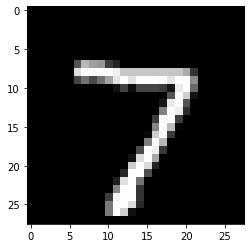

In [26]:
if __name__ == "__main__":
    main()